In [1]:
%matplotlib inline

from functools import partial
from typing import *

import numpy as np
import scipy as sp   # scipy is a popular scientific computing library for Python
import scipy.stats   # statistics package
import matplotlib.pyplot as plt

from ase import Atoms
from ase.calculators.mopac import MOPAC
from ase.io import read, write
from ase.visualize import view

import jax
import jax.numpy as jnp
from jaxlib.xla_extension import DeviceArray

/Users/dehuang/.pyenv/versions/3.9.6/lib/python3.9/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lec 06: Gradient Regression

## Goal

1. Introduce problem of **gradient-regression**.
2. Introduce GPs that fit function values and their gradients.

## Review: Potential Energy Surfaces (PESs)

### Geometry

A **geometry** gives the coordinates of an atomistic system's nuclei in XYZ (Cartesian) coordinates.

In [4]:
h2 = read('h2.xyz')
print("Geometry", h2.get_positions())
view(h2, viewer='x3d')

Geometry [[0.      0.      0.     ]
 [1.14838 0.      0.     ]]


### PES Scan

We will perform a PES "scan" by varying the geometry and recording the corresponding energy and force.

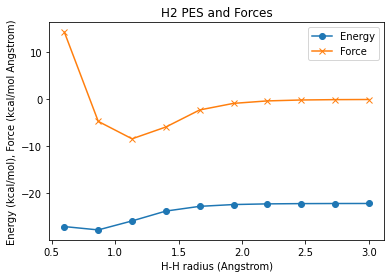

In [7]:
# PES scan of H2 gas as a function of radius between the two H
x = np.zeros((2, 3))
h2 = read('h2.xyz')
h2.set_calculator(MOPAC(label='./tmp/mopac_output', task='PM7 1SCF UHF GRAD DISP'))
rs = np.linspace(0.6, 3.0, 10)
es = []; fs = []
for r in rs:
    x[1, 0] = r
    h2.set_positions(x)
    es += [h2.get_potential_energy()]
    fs += [h2.get_forces()[1, 0]]
    
# PES plot
plt.plot(rs, es, marker="o", label='Energy')
plt.plot(rs, fs, marker="x", label='Force')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol), Force (kcal/mol Angstrom)")
plt.title("H2 PES and Forces"); plt.legend()

### Fact: Forces are negative gradients

The derivative of the PES w.r.t. the XYZ coordinates is the negative force.
$$
\frac{\partial PES}{\partial x} = - force
$$

Text(0.5, 1.0, 'PES with Forces')

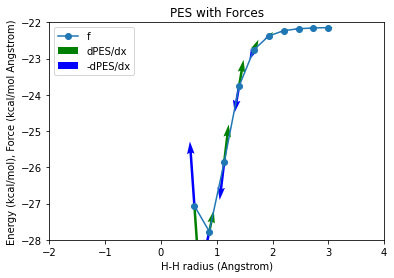

In [15]:
plt.plot(rs, es, marker='o', label='f')
# Plot gradients
origin = np.array([rs, es])
plt.quiver(*origin, np.ones(len(rs)), -np.array(fs), label='dPES/dx', color='green')
plt.quiver(*origin, -np.ones(len(rs)), np.array(fs), label='-dPES/dx', color='blue')
plt.xlim(-2, 4); plt.ylim(-28, -22)
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol), Force (kcal/mol Angstrom)")
plt.legend(); plt.title('PES with Forces')

### Problem: Geometry Optimization

1. The task of locating minima on a PES is called **geometry optimization**.
2. Mathematically we have
$$
argmin_{x} PES(x)
$$
where $x$ are the XYZ coordinates of the atomic system.
3. This corresponds to optimization on a PES until the gradient is -0, i.e., the forces are zero. If there is no force, then the atomistic system does not move.

### Last Time

1. We explored how to fit models to molecular PESs.
2. We showed how fit models could be used to perform geometry optimization on molecular PESs.
3. We began exploring how to use force information to improve our models.

## Gradient Regression

1. Let $(x_i, (y_i, dy_i/dx_i))_i$ be a dataset.
2. Develop a model and a training procedure such that 
$f_\theta(x)$ fits $y$ and $\frac{\partial}{\partial x}f_\theta(x)$ fits $dy_i/dx_i$.

### Synthetic Function in 1D

In [16]:
def f(x) -> np.float64:
    return x**2

def grad_f(x) -> np.float64:
    return 2*x

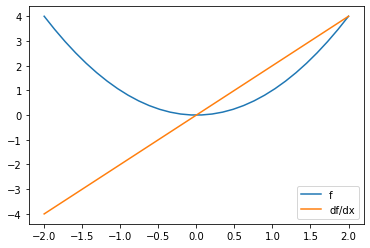

In [17]:
xs = np.linspace(-2, 2, 30)
ys = np.array([f(x) for x in xs])
dy_dxs = np.array([grad_f(x) for x in xs])

plt.plot(xs, ys, label='f')
plt.plot(xs, dy_dxs, label='df/dx')
plt.legend()

### Creating a Synthetic Dataset

In [18]:
idxs = np.arange(xs.shape[0])
np.random.shuffle(idxs)
cutoff = 20
train_idx, test_idx = idxs[:cutoff], idxs[cutoff:]

Text(0.5, 1.0, 'Gradient Regression')

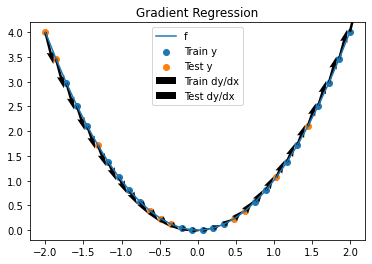

In [19]:
plt.plot(xs, ys, label='f')
plt.scatter(xs[train_idx], ys[train_idx], label='Train y')
plt.scatter(xs[test_idx], ys[test_idx], label='Test y')

# Plot gradients
origin = np.array([xs[train_idx], ys[train_idx]])
plt.quiver(*origin, np.ones(len(train_idx)), dy_dxs[train_idx], label='Train dy/dx')
origin = np.array([xs[test_idx], ys[test_idx]])
plt.quiver(*origin, np.ones(len(test_idx)), dy_dxs[test_idx], label='Test dy/dx')
plt.legend(); plt.title('Gradient Regression')

### Fitting our First Model

1. Like before, we can test with a simple model.
2. We can also use the "easiest" method to fit the model, gradient descent.
3. To do this, we can formulate a loss function.

\begin{align*}
y & = f(x; w) \\
  & = w^T x + w_{D+1} \\
\frac{dy}{dx} & = \nabla_x f(x; w) \\
  & = w
\end{align*}

\begin{align*}
Loss(w) & = \sum_{i=1}^N (y_i - w^T x_i - w_D)^2 + \sum_{i=1}^N \lVert \frac{dy_i}{dx_i} - w \rVert^2 \\
& = \sum_{i=1}^N (y_i - \sum_{j=1}^D w_j x_j - w_D)^2 + \sum_{i=1}^N \sum_{j=1}^D (\frac{dy_i}{dx_i}_{j} - w_{j})^2
\end{align*}

In [21]:
def loss(X, y, g, w):
    A = jnp.concatenate([X, jnp.ones((X.shape[0],1))], axis=1)
    tmp = 0.0
    for x in g:
        tmp += jnp.linalg.norm((w[:-1] - x))
    return jnp.sum((A @ w - y) ** 2) + tmp

def grad_loss(X, y, g, w):
    # Using Jax to take derivatives
    return jax.jacrev(loss, argnums=3)(X, y, g, w)

def grad_desc(X, y, g, w_0, num=10):
    w = np.array(w_0)
    size = 1e-4
    for i in range(num):
        print("Loss", loss(X, y, g, w), "Weights", w)
        w = w - size * grad_loss(X, y, g, w)
    return w

### Training our Model

In [22]:
w_0 = np.array([0., 0.])
X = xs.reshape(-1, 1)
print("Initial loss", loss(X, ys, dy_dxs.reshape(-1, 1), w_0))
w = grad_desc(X, ys, dy_dxs.reshape(-1, 1), w_0, num=10)
loss(X, ys, dy_dxs, w), w

Initial loss 171.60425
Loss 171.60425 Weights [0. 0.]
Loss 170.87512 Weights [-1.9073486e-10  8.5517243e-03]
Loss 170.15472 Weights [-1.9073486e-10  1.7052136e-02]
Loss 169.44293 Weights [-6.675720e-10  2.550155e-02]
Loss 168.73967 Weights [-9.5367425e-10  3.3900265e-02]
Loss 168.04483 Weights [-4.7683713e-10  4.2248588e-02]
Loss 167.35828 Weights [-2.8610225e-10  5.0546821e-02]
Loss 166.67996 Weights [-2.8610225e-10  5.8795266e-02]
Loss 166.00974 Weights [2.861023e-10 6.699422e-02]
Loss 165.34755 Weights [4.768372e-10 7.514398e-02]


(DeviceArray(164.69327, dtype=float32),
 DeviceArray([1.907349e-10, 8.324484e-02], dtype=float32))

### Visualizing Predictions

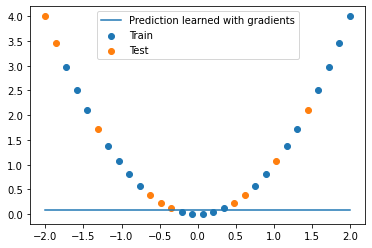

In [23]:
def prediction(weights, x):
    return weights[:-1] @ x + weights[-1]

plt.scatter(xs[train_idx], ys[train_idx], label='Train')
plt.scatter(xs[test_idx], ys[test_idx], label='Test')
plt.plot(xs, [prediction(w, np.array([x])) for x in xs], label='Prediction learned with gradients')
plt.legend()

### PES modeling as a Gradient Regression Problem

Text(0.5, 1.0, 'PES with Forces')

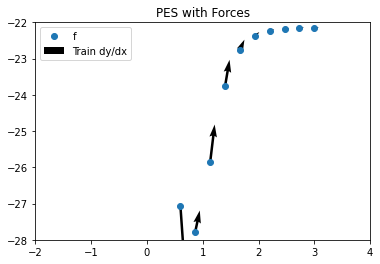

In [24]:
x = np.zeros((2, 3))
h2 = read('h2.xyz')
h2.set_calculator(MOPAC(label='./tmp/mopac_output', task='PM7 1SCF UHF GRAD DISP'))
rs = np.linspace(0.6, 3.0, 10) # radii, 10 points evenly spaced from 0.6 to 3.0
es = []; fs = []
for r in rs:
    x[1, 0] = r
    h2.set_positions(x)
    es += [h2.get_potential_energy()]
    fs += [h2.get_forces()[1, 0]]

plt.plot(rs, es, marker='o', linestyle='None',label='f')
# Plot gradients
origin = np.array([rs, es])
plt.quiver(*origin, np.ones(len(rs)), -np.array(fs), label='Train dy/dx')
plt.xlim(-2, 4); plt.ylim(-28, -22)
plt.legend(); plt.title('PES with Forces')

### 2D Synthetic Functions

In [26]:
def f(x: np.ndarray) -> np.float64:
    return -1*x[0] + 2.*x[1]

def grad_f0(x: np.ndarray) -> np.float64:
    return -1.

def grad_f1(x: np.ndarray) -> np.float64:
    return 2.

def grad_f(x: np.ndarray) -> np.ndarray:
    return np.array([grad_f0(x), grad_f1(x)])

### Plotting Surface

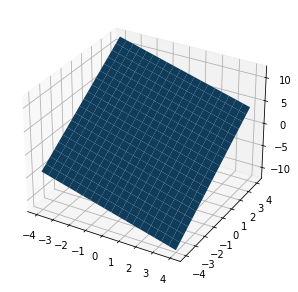

In [27]:
x0s = np.linspace(-4, 4, 20)
x1s = np.linspace(-4, 4, 20)
zs = np.array([[f(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
xx, yy = np.meshgrid(x0s, x1s, indexing='ij')
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zs, alpha=1.)

### Plotting Gradients

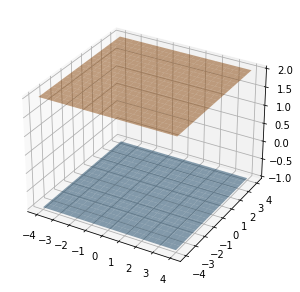

In [28]:
x0s = np.linspace(-4, 4, 20)
x1s = np.linspace(-4, 4, 20)
grad_zs1 = np.array([[grad_f0(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
grad_zs2 = np.array([[grad_f1(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
xx, yy = np.meshgrid(x0s, x1s, indexing='ij')
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, grad_zs1, alpha=.5, label='grad_x0')
ax.plot_surface(xx, yy, grad_zs2, alpha=.5, label='grad_x1')

### Creating a Synthetic Dataset

In [29]:
idxs = np.array([[(i, j) for j in np.arange(len(x1s))] for i in np.arange(len(x0s))]).reshape(-1, 2)
np.random.shuffle(idxs)
cutoff = 300
train_idx, test_idx = idxs[:cutoff], idxs[cutoff:]

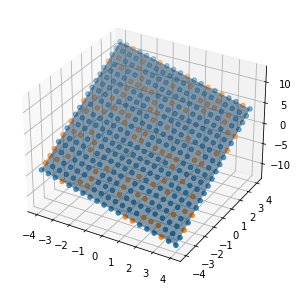

In [30]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]], zs[train_idx[:,0], train_idx[:,1]], label='train')
ax.scatter(xx[test_idx[:,0], test_idx[:,1]], yy[test_idx[:,0], test_idx[:,1]], zs[test_idx[:,0], test_idx[:,1]], label='test')
ax.plot_surface(xx, yy, zs, alpha=.5, label='surface')

In [32]:
def loss(X, y, g, w):
    A = jnp.concatenate([X, jnp.ones((X.shape[0],1))], axis=1)
    tmp = 0.0
    for x in g:
        tmp += jnp.linalg.norm((w[:-1] - x))
    return jnp.sum((A @ w - y) ** 2) + tmp

def grad_loss(X, y, g, w):
    # Using Jax to take derivatives
    return jax.jacrev(loss, argnums=3)(X, y, g, w)

def grad_desc(X, y, g, w_0, num=10):
    w = np.array(w_0)
    size = 1e-4
    for i in range(num):
        print("Loss", loss(X, y, g, w), "Weights", w)
        w = w - size * grad_loss(X, y, g, w)
    return w

In [33]:
X = np.stack([xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]]],axis=1)
y = zs[train_idx[:,0], train_idx[:,1]]
g1 = grad_zs1[train_idx[:,0], train_idx[:,1]]
g2 = grad_zs2[train_idx[:,0], train_idx[:,1]]
g = np.stack([g1, g2], axis=1)

w_0 = np.array([0., 0., 0.])
print("Initial loss", loss(X, y, g, w_0))
weights = grad_desc(X, y, g, w_0, num=10)
loss(X, y, g, weights), weights

Initial loss 9500.87
Loss 9500.87 Weights [0. 0. 0.]
Loss 3967.0588 Weights [-0.37022087  0.7314356  -0.00454737]
Loss 1652.1936 Weights [-0.60829115  1.2052019  -0.00714748]
Loss 683.8224 Weights [-0.76134133  1.5120913  -0.00851138]
Loss 278.70947 Weights [-0.8596961   1.7109026  -0.00909667]
Loss 109.22528 Weights [-0.9228645   1.8397163  -0.00919746]
Loss 38.314175 Weights [-0.96339536  1.9231966  -0.00900246]
Loss 8.642627 Weights [-0.9893539   1.9773201  -0.00863239]
Loss 4.4898787 Weights [-1.0058835   2.0124557  -0.00816426]
Loss 7.132395 Weights [-0.99094796  1.9809344  -0.00764695]


(DeviceArray(5.388644, dtype=float32),
 DeviceArray([-1.0070289 ,  2.0147421 , -0.00723027], dtype=float32))

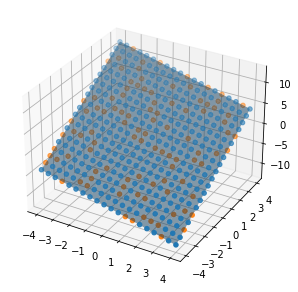

In [34]:
def prediction(weights: np.ndarray, x: np.ndarray) -> np.float64:
    return np.dot(weights[:-1], x) + weights[-1]

pred_zs = np.array([[prediction(weights, np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, pred_zs, alpha=.5, label='prediction')
ax.scatter(xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]], zs[train_idx[:,0], train_idx[:,1]], label='train')
ax.scatter(xx[test_idx[:,0], test_idx[:,1]], yy[test_idx[:,0], test_idx[:,1]], zs[test_idx[:,0], test_idx[:,1]], label='test')

### Summary

1. We explored fitting linear models to targets y and their gradients dy/dx.
2. We saw that modeling PESs falls into this category.
3. We saw 1-D and 2-D versions of the gradient regression problem. This can be arbitrarily extended into N-D.
4. We want models that are more powerful than linear models given that PESs are not linear and neither are the forces.

## GP Regression with Derivatives

1. GPs were our first example of a "non-linear" model.
2. Actually, they are linear models, but in kernel space.
3. Moreover, GPs have a nice property: they can be used to fit targets and derivatives in a consistent manner.
4. We'll explore this property now.

### Review: Fitting PESs with GPs

\begin{align*}
f & \sim GP(\mu, k) \\
y & = f(x)
\end{align*}
where 
1. $f$ is a random function, $x$ is input and $y$ is target
2. $\mu: \mathbb{R}^D \rightarrow \mathbb{R}$ is a mean function
3. $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}$ is a kernel function.

In the case of modeling a PES
1. $f$ is a model of a PES
2. $x$ is a geometry
3. $y$ is an energy

In [35]:
def solve_posterior_predictive_mean(lengthscale: float,
                                    mean: Callable[[np.ndarray], np.ndarray],
                                    kernel: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                    X: np.ndarray,
                                    Y: np.ndarray) -> np.ndarray:
    K = np.stack([np.array([kernel(lengthscale, x1, x2) for x2 in X]).reshape(-1) for x1 in X])
    # Adding noise to the covariance matrix
    K = K + 1e-7*np.eye(K.shape[0])
    b = Y - mean(X)
    # NOTE: this is a naive implementation , typically we can use the special properties of
    # the covariance matrix    
    return np.linalg.solve(K, b)

def predict_posterior_predictive_mean(lengthscale: float,
                                      mean: Callable[[np.ndarray], np.ndarray],
                                      kernel: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                      X: np.ndarray,
                                      alpha: np.ndarray,
                                      xstar: np.ndarray) -> np.ndarray:
    return np.dot(np.array([kernel(lengthscale, x, xstar) for x in X]).reshape(-1), alpha) + mean(xstar)

Text(0.5, 1.0, 'H2 PES')

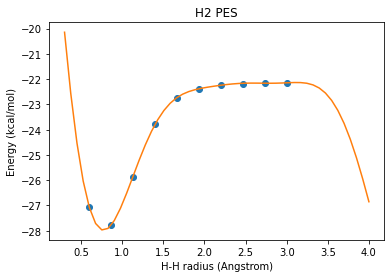

In [36]:
# GP Mean
def mean(x: np.ndarray) -> np.ndarray:
    return np.zeros(x.shape[0])

# GP Kernel (radial basis function)
def kernel(lengthscale: float, x: np.ndarray, y: np.ndarray) -> float:
    return np.exp(-np.dot(x - y, x - y)/(2. * lengthscale**2))

weights = solve_posterior_predictive_mean(1.0, mean, kernel, rs, es)
f_hat = partial(predict_posterior_predictive_mean, 1.0, mean, kernel, rs, weights)

# Plot results
plt.plot(rs, es, marker="o", linestyle="None", label='Dataset')
rs2 = np.linspace(0.3, 4.0)
plt.plot(rs2, np.array([f_hat(np.array([r])) for r in rs2]), label='Model')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol)"); plt.title("H2 PES")

### GP Derivative Property

If $f \sim GP(\mu, k)$, then
$$
\nabla f \sim GP(\frac{\partial}{\partial x} \mu, \frac{\partial^2}{\partial x \partial y}{k})
$$

In words, if our original model of $f$ is drawn from a GP with a certain mean and kernel function, then the gradient of our model $f$ is drawn from a GP with a related mean and kernel.

#### Example: 1D

Suppose
$$
\mu(x) = 0
$$
and
$$
k(x, y) = \exp(-.5 (x-y)^2/l^2)
$$
where the number of dimensions is $1$ for simplicity.

This isn't the most general case, but should get us started on the H2 PES.

#### Example: 1D continued

Then
$$
\nabla f \sim GP(\frac{d}{dx} \mu, \frac{d^2}{d x d y}{k})
$$

where

1.
$$
\frac{d}{d x} \mu = \begin{pmatrix}
0 \\
\vdots \\
0 \\
\end{pmatrix}
$$
2.
$$
\frac{d}{d x} k(x, y) = -\frac{x - y}{l^2}k(x, y)
$$
3. 
$$
\frac{d^2}{dx dy} k(x, y) = \frac{1}{l^2}(1 - (x - y)^2/l^2)k(x, y)
$$

In [37]:
def d_mean_dx(x: np.ndarray) -> np.ndarray:
    return np.zeros(x.shape[0])

def d_kernel_dx(lengthscale: float, x: np.ndarray, y: np.ndarray) -> float:
    prefactor = -(x - y)/lengthscale**2
    return prefactor * kernel(lengthscale, x, y)

def d_kernel_dx_dy(lengthscale: float, x: np.ndarray, y: np.ndarray) -> float:
    prefactor = 1./lengthscale**2 * (1. - (x - y)**2/lengthscale**2)
    return prefactor * kernel(lengthscale, x, y)

### Fitting only Forces

1. The GP derivative property means that we can only fit forces instead of energy.
2. Let's do this now!

In [39]:
# Note that we are using the same solve posterior mean function from before!
weights = solve_posterior_predictive_mean(
    1.0, d_mean_dx, d_kernel_dx_dy, rs, -np.array(fs))

# Note that we are using the same posterior predictive mean from before!
g_hat = partial(
    predict_posterior_predictive_mean,
    1.0, d_mean_dx, d_kernel_dx_dy, rs, weights)

#### Standard Curve Fitting View

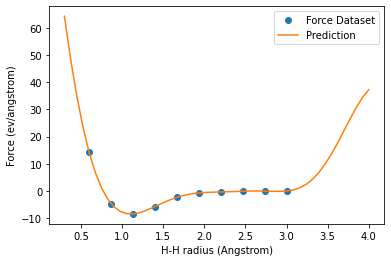

In [42]:
# Plot results using "standard curve fitting view"
plt.plot(rs, fs, marker="o", linestyle="None", label='Force Dataset')
rs2 = np.linspace(0.3, 4.0)
plt.plot(rs2, np.array([-g_hat(np.array([r])) for r in rs2]), label='Prediction')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Force (ev/angstrom)")
plt.legend()

#### As Vector Field

Text(0.5, 1.0, 'PES with Forces')

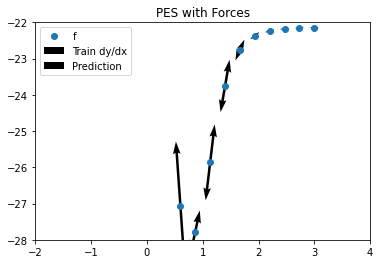

In [43]:
plt.plot(rs, es, marker='o', linestyle='None',label='f')
# Plot gradients
origin = np.array([rs, es])
plt.quiver(*origin, np.ones(len(rs)), -np.array(fs), label='Train dy/dx')
# Plotting prediction of gradient as force
plt.quiver(*origin, -np.ones(len(rs)), np.array([-g_hat(np.array([r])) for r in rs]).reshape(-1), label='Prediction')
plt.xlim(-2, 4); plt.ylim(-28, -22); plt.legend(); plt.title('PES with Forces')

### Obtaining an Energy from a GP fit to Forces?

1. One interesting feature of a GP that is fit to a force is that we can't predict an energy.
2. As a reminder, one useful task in computational chemistry is geometry optimization where we need to find the minima on a PES.
3. While it is useful (paramount) to know the forces, we still need to get an energy out.

#### Posterior Predictive Mean: 1

This posterior predictive distribution of $GP(\mu, k)$ is
\begin{align*}
p(y^* | x^*, y_1, \dots, y_n, x_1, \dots, x_n) & = \mathcal{N}(\mu', K') \,.
\end{align*}
where

1.
$$
\mu' = K(X, x^*)^{T}K(X, X)^{-1}(y - \mu(X)) + \mu(x^*)
$$
2.
$$
K' = K(X, x^*) - K(X, x^*)K(X, X)^{-1}K(X, x^*)
$$

#### Posterior Predictive Mean: 2

Rewriting the posterior predictive mean in non-matrix notation is
$$
f^*(x^*) = \sum_{i=1} \alpha_i k(x^*, x_i) + \mu(x^*)
$$
where 
$$
K(X, X) \alpha = y - \mu(X)
$$

#### Posterior Predictive Mean: 3, Gradient Version

In the case where we fit forces, we have that 
$$
\mu = \frac{\partial}{\partial x}\mu
$$
and
$$
k = \frac{\partial^2}{\partial x \partial y}k \,.
$$

Thus
$$
g^*(x^*) = \sum_{i=1} \alpha_i \frac{\partial^2}{\partial x^* \partial x_i}k(x^*, x_i) + \frac{\partial}{\partial x^*}\mu(x^*)
$$
where 
$$
\frac{\partial^2}{\partial x \partial y}K(X, X) \alpha = y - \frac{\partial}{\partial x}\mu(X) \,.
$$

1. Note that in this case, each $\alpha_i$ is now a length $D$ vector since each $\frac{\partial^2}{\partial x \partial y}k$ gives a $DxD$ matrix instead of a single number.
2. We have changed the prdiction to $g^*$ to signify that it is predicting the gradient.

#### Posterior Predictive Mean: 4, Integrating

1. We have that $g^*(x^*)$ is the prediction of the forces.
2. As a reminder, we also know that this is the gradient of the PES.
3. This enables us to guess that the prediction of the PES is
$$
f^*(x^*) = \sum_{i=1} \alpha_i \frac{\partial}{\partial x_i}k(x^*, x_i) + \mu(x^*)
$$
4. This is justified because
\begin{align*}
\frac{\partial}{\partial x^*}f^*(x^*) & = \frac{\partial}{\partial x^*} \sum_{i=1} \alpha_i \frac{\partial}{\partial x_i}k(x^*, x_i) + \mu(x^*) \tag{definition} \\
& = \sum_{i=1} \alpha_i \frac{\partial^2}{\partial x^* \partial x_i}k(x^*, x_i) + \frac{\partial}{\partial x^*}\mu(x^*) \tag{linearity of derivative} \\
& = g^*(x^*) \tag{definition} \\
\end{align*}
5. The ability to set the prediction of the energy to be the "anti-derivative" of a function is called a *conservative force*. (Technically, we need a path-integral.)

In [46]:
def energy(lengthscale: float,
           mean: Callable[[np.ndarray], np.ndarray],
           d_kernel_dx: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
           X: np.ndarray,
           alpha: np.ndarray,
           xstar: np.ndarray) -> np.ndarray:
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp -= alpha[i] * d_kernel_dx(lengthscale, xstar, X[i])
    return tmp + mean(xstar)

f_hat = partial(energy, 1.0, mean, d_kernel_dx, rs, weights)

Text(0.5, 1.0, 'Fit Forces, Predict Energy')

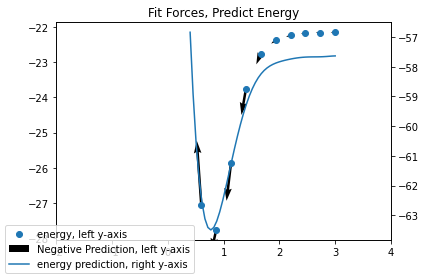

In [47]:
fig, ax1 = plt.subplots()

# Plot energy
ax1.plot(rs, es, marker='o', linestyle='None', label='energy, left y-axis')
# Plot gradients
origin = np.array([rs, es])
# Plotting prediction of gradient as force
ax1.quiver(*origin, -np.ones(len(rs)), np.array([-g_hat(np.array([r])) for r in rs]).reshape(-1), label='Negative Prediction, left y-axis')
ax1.set_xlim(-2, 4)

# Plotting prediction of energy
ax2 = ax1.twinx()
rs2 = np.linspace(0.4, 3.)
ax2.plot(rs2, [f_hat(np.array([r])) for r in rs2], label="energy prediction, right y-axis")
fig.legend(loc='lower left')
plt.title('Fit Forces, Predict Energy')

### Observations

1. The GP that fits forces is only required to interpolate the forces and not the energies!
2. In fact, the energy prediction is way off!
3. Nevertheless, such a model is still useful for the task of geometry optimization.

In [49]:
# We are going to optimize our energy prediction
res = sp.optimize.minimize(f_hat, # 1. Reconstruction of our energy prediction
                           np.array([0.0]),
                           method='L-BFGS-B',
                           jac=g_hat,  # 2. Note that we do know the gradients in this case.
                                       # In other words, we are optimizing our prediction of
                                       # the energy using our prediction of the gradient!
                           bounds=[(0.4, 2.0)])
res # recall the "real" distance is around .74 Angstroms.

      fun: array([-63.49174579])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.00551843e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([0.76930854])

Text(0.5, 1.0, 'Fit Forces, Predict Energy')

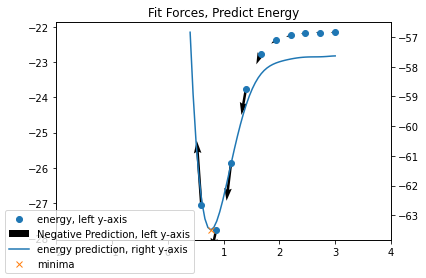

In [50]:
fig, ax1 = plt.subplots()

# Plot energy
ax1.plot(rs, es, marker='o', linestyle='None', label='energy, left y-axis')
# Plot gradients
origin = np.array([rs, es])
# Plotting prediction of gradient as force
ax1.quiver(*origin, -np.ones(len(rs)), np.array([-g_hat(np.array([r])) for r in rs]).reshape(-1), label='Negative Prediction, left y-axis')
ax1.set_xlim(-2, 4)

# Plotting prediction of energy
ax2 = ax1.twinx()
rs2 = np.linspace(0.4, 3.)
ax2.plot(rs2, [f_hat(np.array([r])) for r in rs2], label="energy prediction, right y-axis")

# Plotting minima
ax2.plot(res.x, [f_hat(res.x)], marker='x', linestyle='None', label='minima')
fig.legend(loc='lower left')
plt.title('Fit Forces, Predict Energy')

### Summary

1. We were trying to create a model of H2 PES where we have access to energies and forces.
2. We started with a linear model that just fit energies.
3. We extended the linear model to also fit forces which did not work well.
4. We then fit GPs to the PES energy data which works well for a task such as geometry optimization.
5. We encountered the derivative property of GPs, which enables us to only fit force data for the GP.
6. The "Gradient GP" works well for a task such as geometry optimization even though we need to recover a prediction of the energy that is "off".

### Questions

1. What about the general N-D case?
2. Can we fit both energies and forces?

### Aside: RBF Kernel, General Case

Suppose
$$
\mu(x) = 0
$$
and
$$
k(x, y) = \exp(-.5\lVert x-y \rVert^2/l^2) \,.
$$

Then

1.
$$
\frac{\partial}{\partial x} \mu = \begin{pmatrix}
0 \\
\vdots \\
0 \\
\end{pmatrix}
$$
2.
$$
\frac{\partial}{\partial x} k(x, y) = -\frac{x - y}{l^2}k(x, y)
$$
3. 
$$
\frac{\partial^2}{\partial x \partial y} k(x, y) = \frac{1}{l^2}(I - (x - y) \otimes (x-y)/l^2)k(x, y)
$$
where $\otimes$ is the **outer product** of two vectors, i.e.,
$$
x \otimes y = \begin{pmatrix}
x_1 y_1 & \dots & x_1 y_m \\
\vdots & \ddots & \vdots \\
x_n y_1 & \dots & x_n y_m \\
\end{pmatrix}
$$

#### Ok, the derivation is painful ... Automatic Differentiation to the Rescue

In [51]:
def jax_kernel(x: DeviceArray, y: DeviceArray, length_scale=1.0) -> float:
    # The reason we write it this way is because the second derivative
    # when x=y does not seem to work ...
    scaled_diff = (x - y) / length_scale
    radius2 = jnp.dot(scaled_diff, scaled_diff)
    e = jnp.exp(-0.5 * radius2)
    return e

In [52]:
d_jax_kernel_dx = jax.jacrev(jax_kernel, argnums=0)

# We are using forward-mode AD as opposed to reverse-mode AD here.
# We'll look at the difference later
d_jax_kernel_dx_dy = jax.jacfwd(jax.jacrev(jax_kernel, argnums=0), argnums=1)

In [53]:
# Checking
x = np.array([1.0, 2.0])
y = np.array([-1.2, 0.7])
print(kernel(1.0, x, y), jax_kernel(x, y))
print(d_kernel_dx(1.0, x, y), d_jax_kernel_dx(x, y))
print(d_kernel_dx_dy(1.0, x, y), d_jax_kernel_dx_dy(x, y))

0.03819693508367991 0.038196933
[-0.08403326 -0.04965602] [-0.08403325 -0.04965601]
[-0.14667623 -0.02635589] [[-0.14667621 -0.10924323]
 [-0.10924322 -0.02635588]]


#### Summary

1. We can use automatic differentiation to get higher-level derivatives.
2. It is computationally more intensive to obtain higher-level derivatives.

### Fitting both Energies and Forces

1. Can we fit both energies and forces?
2. Intuitively, fitting forces convey more information about the shape of the PES.
3. Fitting energies gives information about the offset of the PES.

#### Problem

We are interested in finding $\mu?$ and $k?$ such that
$$
\begin{pmatrix}
f \\
\nabla f
\end{pmatrix} \sim GP(\mu?, k?) \,.
$$

#### Solution

We have
$$
\begin{pmatrix}
f \\
\nabla f
\end{pmatrix} \sim GP\left(
\begin{pmatrix}
\mu(x) \\
\frac{d}{dx} \mu(x)
\end{pmatrix}
, 
\begin{pmatrix}
k(x, y) & \frac{d}{dy}k(x, y)^T \\
\frac{d}{dx}k(x, y) & \frac{d^2}{d x d y}{k}(x, y) \\
\end{pmatrix}
\right)
$$

#### Example: 2 points

Fitting a GP to the dataset $\{(x_1, y_1, g_1), (x_2, y_2, g_2)\}$ results in solving
$$
\begin{pmatrix}
k(x_1, x_1) & \frac{d}{dx_1}k(x_1, x_1)^T & k(x_1, x_2) & \frac{d}{dx_2}k(x_1, x_2)^T \\
\frac{d}{dx_1}k(x_1, x_1) & \frac{d^2}{d x_1 d x_1}{k}(x_1, x_1) & \frac{d}{dx_1}k(x_1, x_2) & \frac{d^2}{d x_1 d x_2}{k}(x_1, x_2)\\
k(x_2, x_1) & \frac{d}{dx_1}k(x_2, x_1)^T & k(x_2, x_2) & \frac{d}{dx_2}k(x_2, x_2)^T \\
\frac{d}{dx_2}k(x_2, x_1) & \frac{d^2}{d x_2 d x_1}{k}(x_2, x_1) & \frac{d}{dx_2}k(x_2, x_2) & \frac{d^2}{d x_2 d x_2}{k}(x_2, x_2)
\end{pmatrix}
\begin{pmatrix}
\alpha_1 \\
\beta_1 \\
\alpha_2 \\
\beta_2
\end{pmatrix}
=
\begin{pmatrix}
y_1 - \mu(x_1)\\
g_1 - \frac{d}{dx}\mu(x_1) \\
y_2 - \mu(x_2) \\
g_2 - \frac{d}{dx}\mu(x_2)
\end{pmatrix}
$$
for the weights $\alpha_1, \beta_1, \alpha_2, \beta_2$.

#### Example Continued: Posterior Predictive Mean

The prediction of the function value is
$$
f^*(x^*) = \sum_{i=1}^2 \alpha_i k(x^*, x_i) + \frac{d}{dy}k(x^*, x_i)^T \beta_i + \mu(x^*)
$$

The prediction of the gradient value is
$$
g^*(x^*) = \sum_{i=1}^2 \alpha_i \frac{d}{d x}k(x^*, x_i) + \frac{d^2}{dxdy}k(x^*, x_i) \beta_i + \frac{d}{dx^*}\mu(x^*)
$$

#### Property: Gradient prediction

We have the very interesting property that the prediction of the gradient is equal to the taking the gradient of the energy prediction.

\begin{align*}
\frac{d}{dx^*} f^*(x^*) & = \frac{d}{dx^*}\left( \sum_{i=1}^2 \alpha_i k(x^*, x_i) + \frac{d}{dx_i}k(x^*, x_i)^T \beta_i \right) \\
& = \sum_{i=1}^2 \alpha_i \frac{d}{dx^*} k(x^*, x_i) + \frac{d^2}{dx^* dx_i}k(x^*, x_i) \beta_i \\
& = g^*(x^*)
\end{align*}

#### Property: Covariance

We have that the covariances are

1. 
$$
Cov(f(x), f(y)) = k(x, y)
$$
2. 
$$
Cov(f(x), \nabla f(y)) = \frac{d}{dy}k(x, y)
$$
3.
$$
Cov(\nabla f(x), \nabla f(y)) = \frac{d^2}{dx dy}k(x, y)
$$


1. This is just a reminder that a GP is a linear model in the kernel space.
2. The kernel $k$ is capturing the linear dependence between the prediction of the value and the gradient in the kernel space.

#### Time to Implement!

In [55]:
def kern_blk(x1: DeviceArray, x2: DeviceArray,
             k: Callable[[DeviceArray, DeviceArray], DeviceArray]) -> DeviceArray:
    kern = jnp.array([k(x1, x2)])
    jac2 = jax.jacrev(k, argnums=1)(x1, x2)
    f_jac1 = jax.jacrev(k, argnums=0)
    jac1 = f_jac1(x1, x2).reshape(-1, 1)
    # Using forward-mode AD with reverse-mode AD to get the second derivative
    hes = jax.jacfwd(f_jac1, argnums=1)(x1, x2)

    # Put everything together
    top = jnp.concatenate([kern, jac2]).reshape(1, -1)
    bot = jnp.concatenate([jac1, hes], axis=1)
    K = jnp.concatenate([top, bot])
    return K

x = jnp.array([1.0])
print(x.shape)
kern_blk(x, x, jax_kernel)

(1,)


DeviceArray([[ 1.,  0.],
             [-0.,  1.]], dtype=float32)

In [57]:
def solve(mean: Callable[[DeviceArray], DeviceArray],
          kernel: Callable[[DeviceArray, DeviceArray], DeviceArray],
          X: DeviceArray,
          Y: DeviceArray) -> DeviceArray:
    K = jnp.concatenate([
            jnp.concatenate([
                kern_blk(x1, x2, kernel) for x2 in X
            ], axis=1) for x1 in X
        ])
    K = K + jnp.diag(1e-5*jnp.ones(K.shape[0]))
    Y_p = jnp.concatenate([jnp.array(y) for y in Y])
    mu_p = jnp.concatenate([
        jnp.concatenate([
            jnp.array([mean(x)]), jax.jacrev(mean)(x).reshape(-1)
        ]) for x in X])
    b = (Y_p - mu_p).reshape(-1, 1)
    return jnp.linalg.solve(K, b)

In [58]:
X = rs.reshape(-1, 1)
Y = jnp.stack([jnp.array(es), -jnp.array(fs)], axis=1)
weights = solve(lambda x: 0.0, jax_kernel, X, Y)
weights, weights.reshape(X.shape[0], -1)

(DeviceArray([[-14930.486  ],
              [ -5784.5737 ],
              [  4596.449  ],
              [ 10484.65   ],
              [ -5638.5156 ],
              [-25976.537  ],
              [  6322.559  ],
              [ 16770.104  ],
              [  2446.782  ],
              [-13405.1    ],
              [  1653.9857 ],
              [  2378.5874 ],
              [  1888.9047 ],
              [ -2410.1914 ],
              [  1240.2999 ],
              [  -778.7873 ],
              [  1306.5876 ],
              [   -97.54605],
              [  1132.6124 ],
              [  -336.22604]], dtype=float32),
 DeviceArray([[-14930.486  ,  -5784.5737 ],
              [  4596.449  ,  10484.65   ],
              [ -5638.5156 , -25976.537  ],
              [  6322.559  ,  16770.104  ],
              [  2446.782  , -13405.1    ],
              [  1653.9857 ,   2378.5874 ],
              [  1888.9047 ,  -2410.1914 ],
              [  1240.2999 ,   -778.7873 ],
              [  1306.5876 ,   

In [59]:
def predict_value(mean: Callable[[DeviceArray], DeviceArray],
                  kernel: Callable[[DeviceArray, DeviceArray], DeviceArray],
                  weights: DeviceArray,
                  X: DeviceArray,
                  xstar: DeviceArray) -> DeviceArray:
    weights = weights.reshape(X.shape[0], -1)
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += kernel(xstar, X[i]) * weights[i][0] + jnp.dot(weights[i][1:], jax.jacrev(kernel, argnums=1)(xstar, X[i]))
    tmp + mean(xstar)
    return tmp

Text(0.5, 1.0, 'H2 PES')

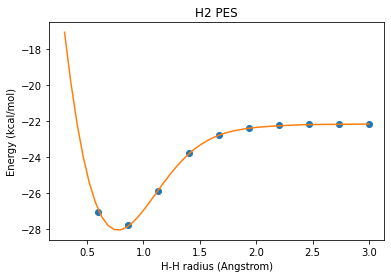

In [60]:
# Plot results
plt.plot(rs, es, marker="o", linestyle="None", label='Dataset')
rs2 = np.linspace(0.3, 3.0)
f_hat = partial(predict_value, lambda x: 0.0, jax_kernel, weights, X)
plt.plot(rs2, np.array([f_hat(np.array([r])) for r in rs2]), label='Model')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol)"); plt.title("H2 PES")

In [61]:
def predict_gradient(mean: Callable[[DeviceArray], DeviceArray],
                     kernel: Callable[[DeviceArray, DeviceArray], DeviceArray],
                     weights: DeviceArray,
                     X: DeviceArray,
                     xstar: DeviceArray) -> DeviceArray:
    weights = weights.reshape(X.shape[0], -1)
    tmp = jnp.zeros(X.shape[1])
    for i in range(X.shape[0]):
        tmp += jax.jacrev(kernel, argnums=0)(xstar, X[i]) * weights[i][0] + jnp.dot(weights[i][1:], jax.jacfwd(jax.jacrev(kernel, argnums=1), argnums=0)(xstar, X[i]))
    tmp + mean(xstar)
    return tmp

Text(0.5, 1.0, 'PES with Forces')

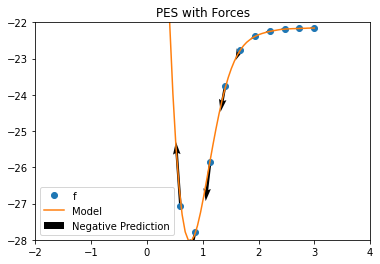

In [62]:
plt.plot(rs, es, marker='o', linestyle='None',label='f')
rs2 = np.linspace(0.3, 3.0)
f_hat = partial(predict_value, lambda x: 0.0, jax_kernel, weights, X)
plt.plot(rs2, np.array([f_hat(np.array([r])) for r in rs2]), label='Model')
# Plot gradients
origin = np.array([rs, es])
# Plotting prediction of gradient as force
g_hat = partial(predict_gradient, lambda x: 0.0, jax_kernel, weights, X)
plt.quiver(*origin, -np.ones(len(rs)), np.array([-g_hat(np.array([r])) for r in rs]).reshape(-1), label='Negative Prediction')
plt.xlim(-2, 4); plt.ylim(-28, -22); plt.legend(); plt.title('PES with Forces')

### Summary

1. We've seen how to use the original GP model unchanged to directly fit forces.
2. The issue here was that we needed to recover the energy prediction which was way off, even though it is still useful for geometry optimization.
3. We then saw how to fit both energies and forces.
4. This model can be seen as a baseline for the gradient regression problem since it is the "linear model" that fits both values and gradients in a consistent manner.

## Towards Better Gradient Regression Models

1. We've finally finished our journey up until the simplest gradient regression model.
2. Gaussian process regression is already used in chemistry [https://pubs.acs.org/doi/pdf/10.1021/acs.chemrev.1c00022](https://pubs.acs.org/doi/pdf/10.1021/acs.chemrev.1c00022)
3. Now it's up to us as a class to improve models that fit gradients!

### Avenues

1. We can change the loss function.
2. We can change the model.
3. We can take advantage of the data.
4. We can change the training procedure.
5. We can try to transfer PESs from simpler molecules to more complex molecules.